In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Table of content
1. Define functions, load data
    - Import `interactive` maps module
    - Define functions for calculating `distance` on Earth
    - Load DataFrames for `apartaments` and `metro` 
2. Prepare data
    - Add `price` to `rental price` in order to get `real price`
    - Find `distance` to nearest metro station for all valid houses
    - Find `distance` to city center (`PKiN`) for all valid houses
    - Read `districts'` shape data
    - Assign `districts` to all houses 
3. Analyse dataset
    - Price `violinplots` for each district
    - Show median price for each district (**interactive map**) 
    - Correlate `data` (**with strong interpreations**)
    - `Big heatmap` with exageratted colors
    - Various interesting `correlated plots`
    - Distribution of apartment's floor level
4. Prediction
    - Linear regressor and `support vector mashines`
    - Analyse of `error` in regression approach
    - Test on some hand-typed data 

# 1. Define functions, load data

## 1.1. Import interactive maps module

In [2]:
import geopandas as gpd
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

In [3]:
# Function for displaying the map

def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='500px')

## 1.2. Define functions for calculating distance on Earth

In [4]:
# Using geopy
import geopy.distance

def dist(a, b):
    return geopy.distance.geodesic((a.x, a.y), (b.x, b.y)).km

In [5]:
# Using geopandas
def dist_2(a, b):
    a = gpd.GeoSeries(Point(a.y, a.x), crs=({"init":"epsg:4326"})).to_crs(epsg=3310)
    b = gpd.GeoSeries(Point(b.y, b.x), crs=({"init":"epsg:4326"})).to_crs(epsg=3310)
    return a.distance(b) / 1000

## 1.3. Load DataFrames for `apartaments` and `metro`

In [6]:
apartaments = pd.read_csv("apartaments.csv")
metro = pd.read_csv("metro.csv")

# 2. Prepare data

## 2.1. Add `price` to `rental price` in order to get `real price`

In [7]:
# Function to check if value is Nan or not
def notNan(a):
    return a == a

In [8]:
def real_price(row):
    if notNan(row['Czynsz - dodatkowo']):
        return int(row['Cena']) + int(row['Czynsz - dodatkowo'])
    else:
        return int(row['Cena'])

In [9]:
if 'Cena rzeczywista' in apartaments or not 'Cena' in apartaments:
    print("Reloading apartamens.csv file")
    apartaments = pd.read_csv("apartaments.csv")
    
apartaments.insert(1, "Cena rzeczywista", apartaments.apply(real_price, axis=1))
#apartaments = apartaments.drop(columns = ['Cena', 'Czynsz - dodatkowo'])

## 2.2. Find distance to nearest metro station for all valid houses

In [10]:
nearest_metro_dist = []
nearest_metro_name = []

for idx, house in apartaments.iterrows():
    if notNan(house['φ']):
        list_ = [dist(Point(house['φ'], house['λ']), Point(station['φ'], station['λ']))
                 for jdx, station in metro.iterrows()]
        nearest_metro_dist.append(round(min(list_), 4))
        nearest_metro_name.append(metro.iloc[np.argmin(list_)]['Nazwa'])
    else:
        nearest_metro_dist.append(np.nan)
        nearest_metro_name.append(np.nan)
        
        
if "Odległość od najbliższej stacji metra" in apartaments:
    apartaments = apartaments.drop('Odległość od najbliższej stacji metra', axis=1)
apartaments.insert(apartaments.shape[1], "Odległość od najbliższej stacji metra", nearest_metro_dist)

if "Najbliższa stacja metra" in apartaments:
    apartaments = apartaments.drop('Najbliższa stacja metra', axis=1)
apartaments.insert(apartaments.shape[1], "Najbliższa stacja metra", nearest_metro_name)

## 2.3. Find distance to city center (`PKiN`) for all valid houses

In [11]:
city_center_dist = []

for idx, house in apartaments.iterrows():
    if notNan(house['φ']):
        city_center_dist.append(round(dist(Point(house['φ'], house['λ']), Point(52.2323, 21.0000)), 4))
    else:
        city_center_dist.append(np.nan)
        
        
if "Odległość od centrum" in apartaments:
    apartaments = apartaments.drop("Odległość od centrum", axis=1) 
apartaments.insert(apartaments.shape[1], "Odległość od centrum", city_center_dist) 

## 2.4. Read districts' shape data

In [12]:
geo = gpd.read_file("districts/warszawa_dzielnice.shp").to_crs({'init': 'epsg:4326'})
geo = geo.drop(0).reset_index().drop(columns=['index', 'cartodb_id'])

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


## 2.5. Assign districts to all houses

In [13]:
def assign_district(row):
    point = Point(row['λ'], row['φ'])
    if notNan(row['φ']):
        return np.argmax([polygon.contains(point) for polygon in geo['geometry']])
    else:
        return np.nan

apartaments['Numer dzielnicy'] = apartaments.apply(assign_district, axis=1)
apartaments['Nazwa dzielnicy'] = apartaments['Numer dzielnicy'].apply(
    lambda x: geo.iloc[int(x)]['name'] if notNan(x) else np.nan)

# 3. Analyse dataset

In [14]:
apartaments.head()

,Cena,Cena rzeczywista,Kaucja,Powierzchnia,Liczba pokoi,Rodzaj zabudowy,Piętro,Okna,Ogrzewanie,Stan wykończenia,...,Czynsz - dodatkowo,Liczba pięter,Materiał budynku,Rok budowy,Czas dojazdu do centrum,Odległość od najbliższej stacji metra,Najbliższa stacja metra,Odległość od centrum,Numer dzielnicy,Nazwa dzielnicy
0,2400,2400,2400.0,48.0,3,blok,2,plastikowe,miejskie,do zamieszkania,...,NaN,NaN,NaN,NaN,25.0,2.3963,Metro Stadion Narodowy,4.5333,7.0,Praga Południe
1,2400,2900,3000.0,45.0,2,apartamentowiec,2,plastikowe,miejskie,do zamieszkania,...,500.0,5.0,cegła,2014.0,36.0,0.2076,Metro Młociny,7.9005,5.0,Bielany
2,2600,2600,NaN,40.0,2,apartamentowiec,4,plastikowe,miejskie,do zamieszkania,...,NaN,6.0,pustak,2018.0,31.0,2.1875,Metro Wierzbno,4.7630,6.0,Mokotów
3,2300,2700,2500.0,54.0,2,blok,1,plastikowe,miejskie,do zamieszkania,...,400.0,5.0,NaN,2007.0,46.0,1.3607,Metro Trocka,7.2078,10.0,Targówek
4,2950,3300,NaN,54.0,3,blok,3,drewniane,miejskie,do zamieszkania,...,350.0,4.0,cegła,2016.0,47.0,2.3051,Metro Natolin,10.4301,15.0,Wilanów


## 3.1. Price violinplots for each district

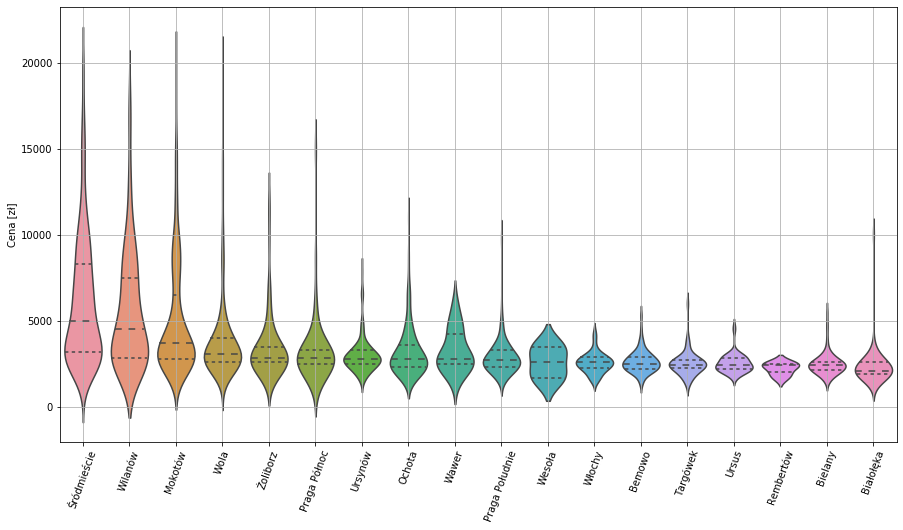

In [15]:
#df = apartaments[apartaments['Powierzchnia'] <= 60]
df = apartaments[apartaments['Cena rzeczywista'] <= 20000]

order = df.groupby('Nazwa dzielnicy')['Cena rzeczywista'].describe()['50%'].sort_values(ascending=False)

plt.figure(figsize=(15,8))
sns.violinplot(data=df, x='Nazwa dzielnicy', y='Cena rzeczywista', order=order.index, inner='quartile'
               , orient='v', scale='width')
plt.xticks(rotation=70)
plt.ylabel('Cena [zł]')
plt.xlabel('')
#plt.yticks(np.arange(0,21000,1000))
plt.grid()

*All violinplots are ordered by median price.*
## Comment:

All districts contain a lot of "`cheap`" apartaments with prices around `2000-3000 zł`. Addictionally, we notice that first 3 districts (`Śródmieście, Wilanów, Mokotów`) also contain comparable amount of more expensive apartaments, with prices around `8000 zł`. We distinct these two ranges by increased local tickness of violins.

## 3.2. Show median price for each district

In [16]:
plot_dict = apartaments.groupby('Numer dzielnicy')['Cena rzeczywista'].describe()['50%']
plot_dict.index = [str(i) for i in range(0,18)]

In [17]:
pd.DataFrame(apartaments.groupby('Nazwa dzielnicy')['Cena rzeczywista'].describe()['50%'].astype('int32').rename('Mediana cen [zł]').sort_values(ascending=False))

,Mediana cen [zł]
Nazwa dzielnicy,
Śródmieście,5300
Wilanów,4500
Mokotów,3700
Wola,3100
Żoliborz,2850
Praga Północ,2810
Ursynów,2800
Ochota,2800
Wawer,2775


In [18]:
# Create a base map
m_1 = folium.Map(location=[52.2323,21.0000], tiles='cartodbpositron', zoom_start=10)

# Add apartaments to the map
mc = MarkerCluster()
for idx, house in apartaments.iterrows():
    if notNan(house['φ']):
        mc.add_child(Marker([house['φ'], house['λ']], popup=str(house['Cena rzeczywista']) + "zł"))
m_1.add_child(mc)

# Add districts coloured by median price to the map
Choropleth(geo_data=geo.__geo_interface__, 
           data=plot_dict,
           key_on="feature.id", 
           fill_color='YlGnBu', 
           legend_name='Mediana cen [zł]',
          ).add_to(m_1)

# Display the map
embed_map(m_1, 'maps/m_1.html')

In [19]:
apartaments.head()

,Cena,Cena rzeczywista,Kaucja,Powierzchnia,Liczba pokoi,Rodzaj zabudowy,Piętro,Okna,Ogrzewanie,Stan wykończenia,...,Czynsz - dodatkowo,Liczba pięter,Materiał budynku,Rok budowy,Czas dojazdu do centrum,Odległość od najbliższej stacji metra,Najbliższa stacja metra,Odległość od centrum,Numer dzielnicy,Nazwa dzielnicy
0,2400,2400,2400.0,48.0,3,blok,2,plastikowe,miejskie,do zamieszkania,...,NaN,NaN,NaN,NaN,25.0,2.3963,Metro Stadion Narodowy,4.5333,7.0,Praga Południe
1,2400,2900,3000.0,45.0,2,apartamentowiec,2,plastikowe,miejskie,do zamieszkania,...,500.0,5.0,cegła,2014.0,36.0,0.2076,Metro Młociny,7.9005,5.0,Bielany
2,2600,2600,NaN,40.0,2,apartamentowiec,4,plastikowe,miejskie,do zamieszkania,...,NaN,6.0,pustak,2018.0,31.0,2.1875,Metro Wierzbno,4.7630,6.0,Mokotów
3,2300,2700,2500.0,54.0,2,blok,1,plastikowe,miejskie,do zamieszkania,...,400.0,5.0,NaN,2007.0,46.0,1.3607,Metro Trocka,7.2078,10.0,Targówek
4,2950,3300,NaN,54.0,3,blok,3,drewniane,miejskie,do zamieszkania,...,350.0,4.0,cegła,2016.0,47.0,2.3051,Metro Natolin,10.4301,15.0,Wilanów


## 3.3. Correlate data

In [733]:
df = apartaments.copy().drop(columns=['Cena', 'Czynsz - dodatkowo', 'Kaucja', 'Numer dzielnicy'])

# Convert string values to integers
def Encode(df):
    for column in df.columns[df.columns.isin(['Okna', 'Piętro'])]:
        df[column] = df[column].factorize()[0]
        
    # Convert number of rooms to integer type in all cases
    for column in ['Liczba pokoi']:
        for i in range(len(df[column])):
            if df[column].iloc[i] == 'parter':
                df[column].iloc[i] = 0
            elif df[column].iloc[i] == 'więcej niż 10' or df[column].iloc[i] == 'poddasze':
                df[column].iloc[i] = 10
            else:
                df[column].iloc[i] = int(df[column].iloc[i])
    return df


# Apply relevant conditions
df = df[df['Cena rzeczywista'] <= 20000]  # There is one `epic` outlier that has to be ommited
df = Encode(df)

## 3.4. Big heatmap with exageratted colors
source: https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

,Cena rzeczywista,Powierzchnia,Liczba pokoi,Piętro,Okna,φ,λ,Liczba pięter,Rok budowy,Czas dojazdu do centrum,Odległość od najbliższej stacji metra,Odległość od centrum
Cena rzeczywista,1.000000,0.818016,0.621825,0.102640,0.023939,-0.086982,0.072704,0.046620,0.024372,-0.259233,-0.092035,-0.163342
Powierzchnia,0.818016,1.000000,0.812355,0.033742,-0.001043,-0.157969,0.109841,-0.014445,0.009074,-0.040216,-0.038528,-0.029712
Liczba pokoi,0.621825,0.812355,1.000000,0.009882,-0.022759,-0.157061,0.095108,-0.023383,0.017341,0.018163,-0.010658,0.009536
Piętro,0.102640,0.033742,0.009882,1.000000,-0.006238,0.013859,-0.040481,0.086385,0.141959,-0.133639,-0.028017,-0.063177
Okna,0.023939,-0.001043,-0.022759,-0.006238,1.000000,-0.041107,0.017771,-0.013860,0.110598,0.060591,-0.007791,0.015386
φ,-0.086982,-0.157969,-0.157061,0.013859,-0.041107,1.000000,-0.237426,0.031801,-0.069909,-0.151751,0.081007,-0.097518
λ,0.072704,0.109841,0.095108,-0.040481,0.017771,-0.237426,1.000000,-0.019489,-0.050939,0.139908,-0.702821,-0.506715
Liczba pięter,0.046620,-0.014445,-0.023383,0.086385,-0.013860,0.031801,-0.019489,1.000000,0.050582,-0.057500,-0.018563,-0.036513
Rok budowy,0.024372,0.009074,0.017341,0.141959,0.110598,-0.069909,-0.050939,0.050582,1.000000,0.279800,0.098272,0.180710
Czas dojazdu do centrum,-0.259233,-0.040216,0.018163,-0.133639,0.060591,-0.151751,0.139908,-0.057500,0.279800,1.000000,0.579268,0.876762


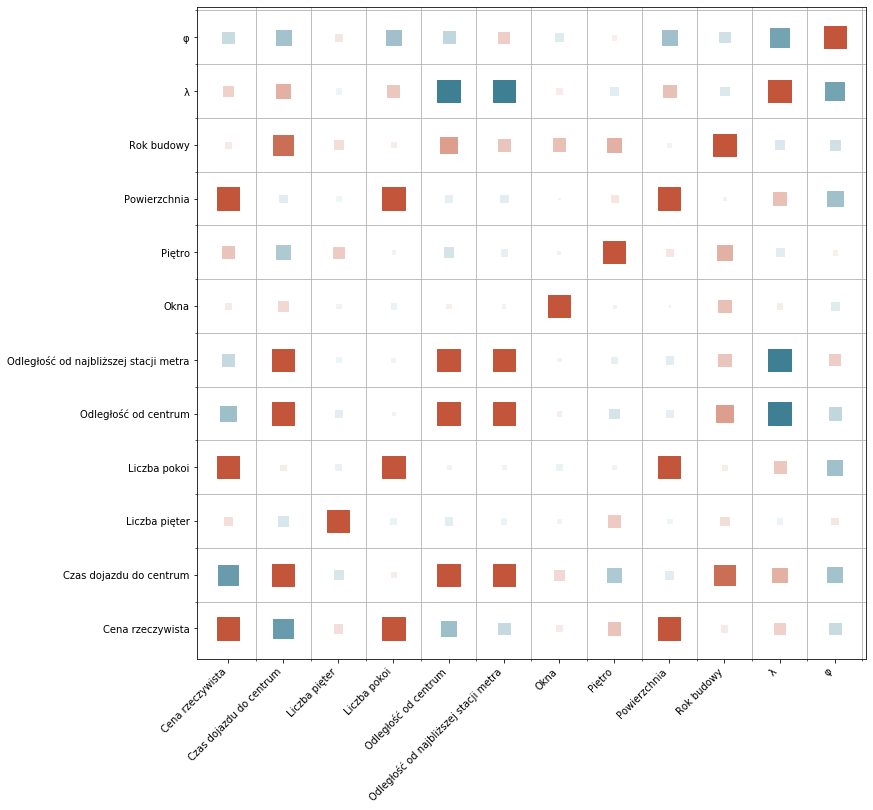

In [737]:
corr = df.corr()  #.style.background_gradient(cmap='coolwarm')
display(corr)

n_colors = 256 # Use 256 colors for the diverging color palette
palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

def value_to_color(val):
    val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
    ind = int(val_position * (n_colors - 1)) # target index in the color palette
    return palette[ind]


def heatmap(x, y, size, color):
    fig, ax = plt.subplots()
    fig.set_figheight(12)
    fig.set_figwidth(12)
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        c=color.apply(value_to_color), # Vector of square color values, mapped to color palette
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)


corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    # Exaggerate colors to stress if there is ANY correlation, even little
    size=corr['value'].abs().apply(lambda x: min(1, 3*x)), 
    color=-corr['value'].apply(lambda x: max(-1, min(1, 3*x)))
)

## 3.5. Various interesting correlated plots

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text xticklabel objects>)

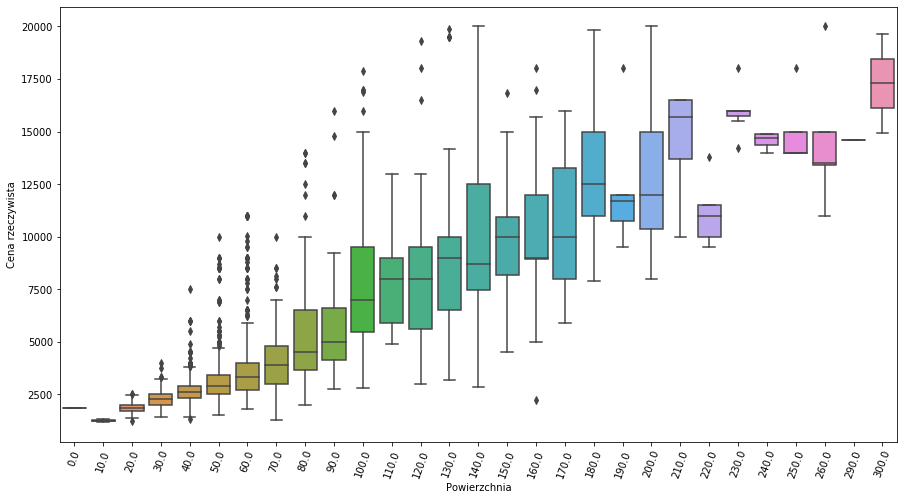

In [377]:
plt.figure(figsize=(15,8))
sns.boxplot('Powierzchnia', 'Cena rzeczywista', data=df.apply
           (lambda x: round(x/10)*10 if x.name == 'Powierzchnia' else x))
plt.xticks(rotation=70)

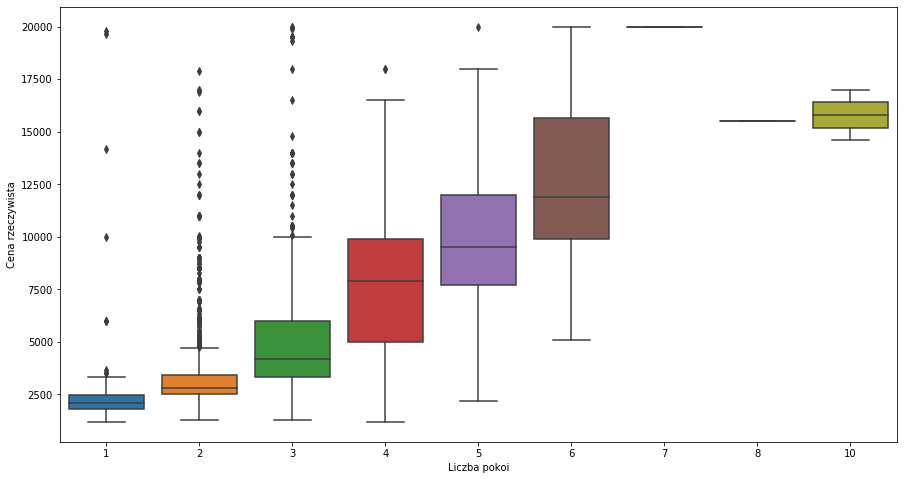

In [378]:
plt.figure(figsize=(15,8))
sns.boxplot('Liczba pokoi', 'Cena rzeczywista', data=df)

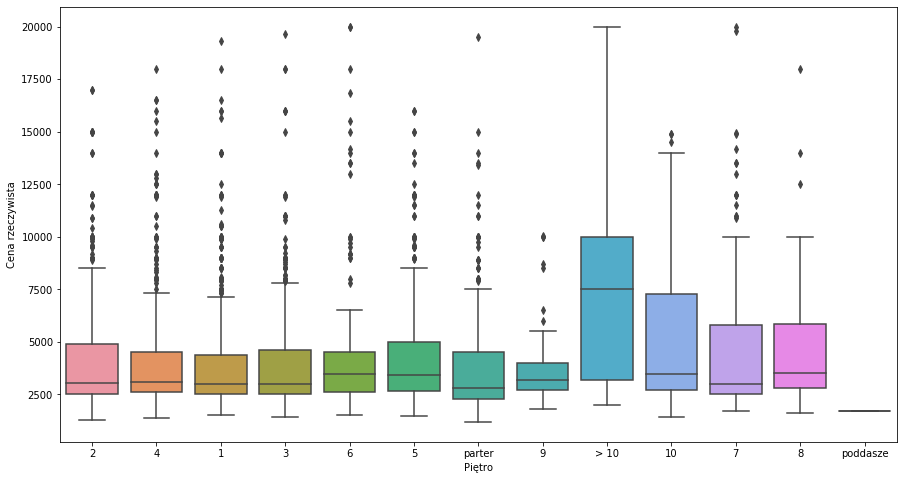

In [379]:
plt.figure(figsize=(15,8))
sns.boxplot('Piętro', 'Cena rzeczywista', data=df)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]), <a list of 21 Text xticklabel objects>)

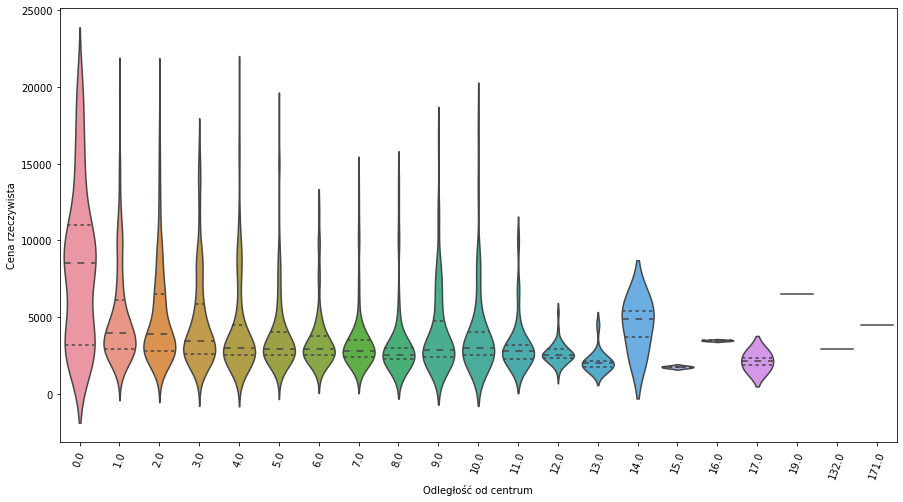

In [740]:
plt.figure(figsize=(15,8))
sns.violinplot('Odległość od centrum', 'Cena rzeczywista', data=df.apply
           (lambda x: round(x/1)*1 if x.name == 'Odległość od centrum' else x), showfliers=False, scale='width', inner='quartile')
plt.xticks(rotation=70)
#plt.ylim(1000, 5000)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

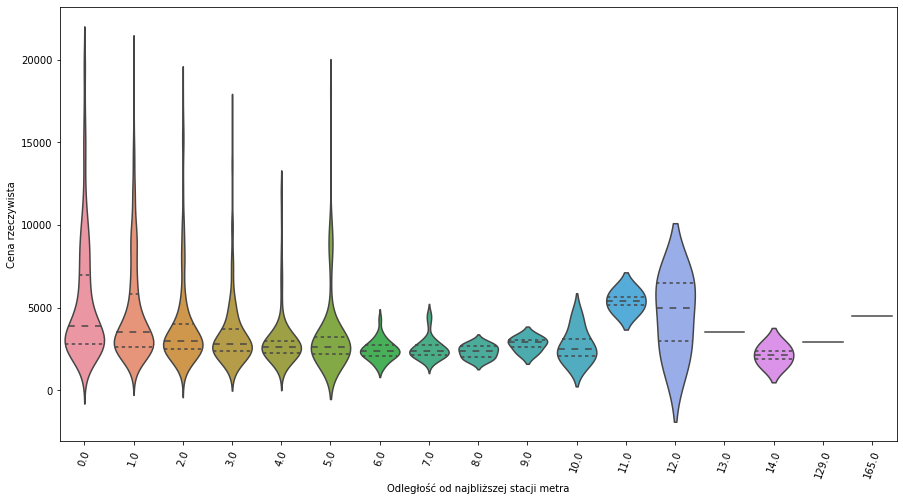

In [741]:
plt.figure(figsize=(15,8))
sns.violinplot('Odległość od najbliższej stacji metra', 'Cena rzeczywista', data=df.apply
           (lambda x: round(x/1)*1 if x.name == 'Odległość od najbliższej stacji metra' else x), showfliers=False, scale='width', inner='quartile')
plt.xticks(rotation=70)
#plt.ylim(1000, 7500)

Text(0.5, 0, 'Czas dojazdu do centrum [minuty]')

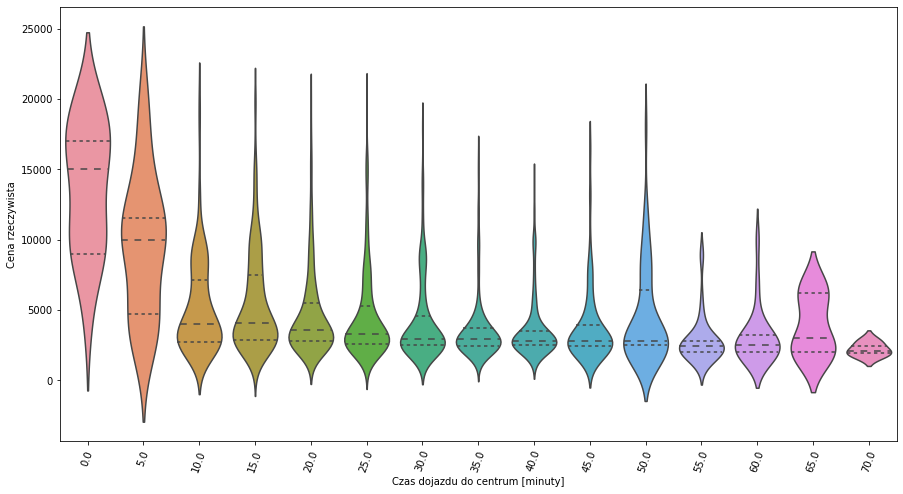

In [610]:
plt.figure(figsize=(15,8))
sns.violinplot('Czas dojazdu do centrum', 'Cena rzeczywista', data=df.apply
           (lambda x: round(x/5)*5 if x.name == 'Czas dojazdu do centrum' else x), showfliers=False, scale='width', inner='quartile')
plt.xticks(rotation=70)
plt.xlabel('Czas dojazdu do centrum [minuty]')

Text(0, 0.5, 'Odległość od centrum [km]')

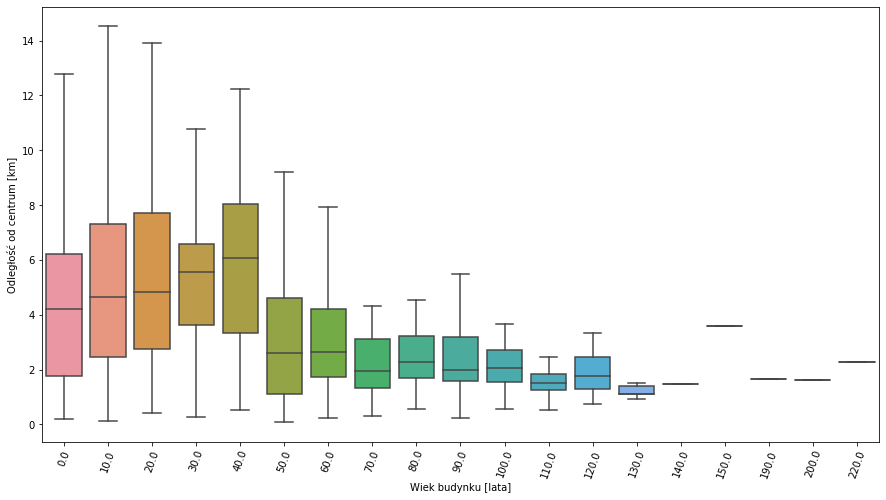

In [26]:
plt.figure(figsize=(15,8))
sns.boxplot('Rok budowy', 'Odległość od centrum', data=df.apply
           (lambda x: round((2019-x)/10)*10 if x.name == 'Rok budowy' else x), showfliers=False)
plt.xticks(rotation=70)
#plt.ylim(0,15)
plt.xlabel('Wiek budynku [lata]')
plt.ylabel('Odległość od centrum [km]')

Text(0, 0.5, 'Cena [zł]')

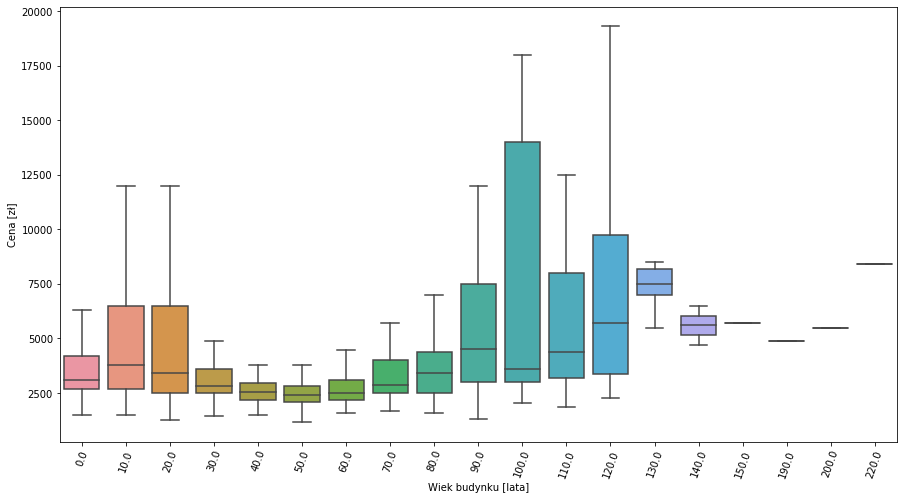

In [27]:
plt.figure(figsize=(15,8))
sns.boxplot('Rok budowy', 'Cena rzeczywista', data=df.apply
           (lambda x: round((2019-x)/10)*10 if x.name == 'Rok budowy' else x), showfliers=False)
plt.xticks(rotation=70)
#plt.ylim(0,15)
plt.xlabel('Wiek budynku [lata]')
plt.ylabel('Cena [zł]')

## Comments:
- `price` and `area of house` relation is `strongly linear`
- `price` and `number of rooms` relation is `strongly linear`
- there is `no relation` between `price` and `floor number`
- there is `some correlation` between `price` and `distance to city center`, aswell as between `nearest metro station location` and `price`. Noticably, there is a peak of price at a distance `~9 km` from city center. It's because exactly in `9 km` there is district `Wilanów`, which is a rich quarter of Warsaw and its prices are not connected with commutation. Peaks at `10.5 km` and `12.5 km` at `nearest metro station location` plot are caused by single houses at district `Wawer` and can be ignored.
- analysing `building's age` and `distance from city center` leads to conclusion, that Warsaw was destroyed in WWII and is being rebuilded starting from city center to `outside direction`
- from `price` vs `building's age` plot we see that the minimum price is for `age = 50 years` (buildings build at year 1970). New buldings aswell as very old buldings are `worth the most`.

# 3.4. Distribution of apartment's floor level

Text(0, 0.5, 'Ilość mieszkań')

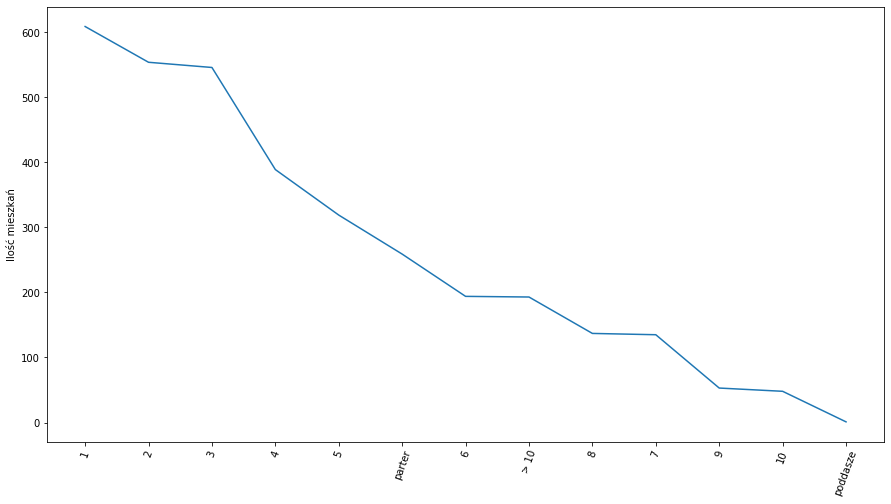

In [28]:
plt.figure(figsize=(15,8))
plt.plot(apartaments['Piętro'].value_counts())
plt.xticks(rotation=70)
plt.ylabel('Ilość mieszkań')

## Comment:
Most apartaments are suprisingly located not on the `groud floor` (parter), but rather on 1st, 2nd or 3rd floor.

# 4. Prediction

## 4.1. Linear regressor and support vector mashines (SVM)
An approach to predict value of a property basing on its `area`, `number of rooms`, `year of build` and `location`.

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score

In [722]:
# Prepare input and target

df = apartaments.copy()
df = df[df['Cena rzeczywista'] <= 20000]  # Cut one big outlier
                      
X = ['Powierzchnia', 'Liczba pokoi', 'φ', 'λ', 'Rok budowy', 'Czas dojazdu do centrum']
Y = ['Cena rzeczywista']
Y = ['Cena rzeczywista']

df = df[X + Y].dropna() # Drop Nans

x = Encode(df[X].copy()) # Convert string values to integers
y = df[Y]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [723]:
# Split into equal (or not) lenght train and test sets

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.3, random_state = 324)
print(x_train.shape, x_test.shape)

(1540, 6) (660, 6)


In [724]:
# Scale train and test set, basing only on train data

scaler_x = StandardScaler().fit(x_train)
x_train = scaler_x.transform(x_train)
x_test = scaler_x.transform(x_test)

In [725]:
# Choose and learn classifier

regressor = SVR(C=100000, gamma=0.1) 
#regressor = LinearRegression()
regressor.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=100000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Mean square error is 1033.9637821433707
R^2 score is 0.8912617816887025


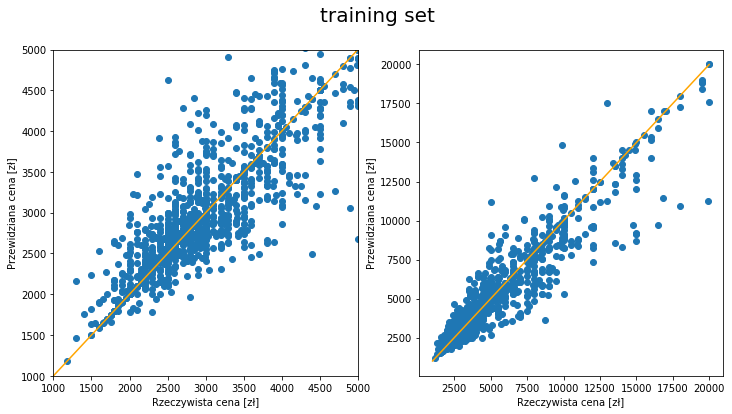

In [726]:
# Calculate error on train set

fig = plt.figure(figsize=(12,6))
y_pred_train = regressor.predict(x_train)

fig.add_subplot(1,2,1)
plt.scatter(y_train, y_pred_train)
plt.plot([1000, 20000], [1000, 20000], color='orange')
plt.xlabel('Rzeczywista cena [zł]')
plt.ylabel('Przewidziana cena [zł]')
plt.xlim(1000, 5000)
plt.ylim(1000, 5000)

fig.add_subplot(1,2,2)
plt.scatter(y_train, y_pred_train)
plt.plot([1000, 20000], [1000, 20000], color='orange')
plt.xlabel('Rzeczywista cena [zł]')
plt.ylabel('Przewidziana cena [zł]')
fig.suptitle('training set', fontsize=20)

mse = np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred_train))
r2 = r2_score(y_train, y_pred_train)
print("Mean square error is {}\nR^2 score is {}".format(mse, r2))

Mean square error is 1139.9613658197998
R^2 score is 0.8727334386765885


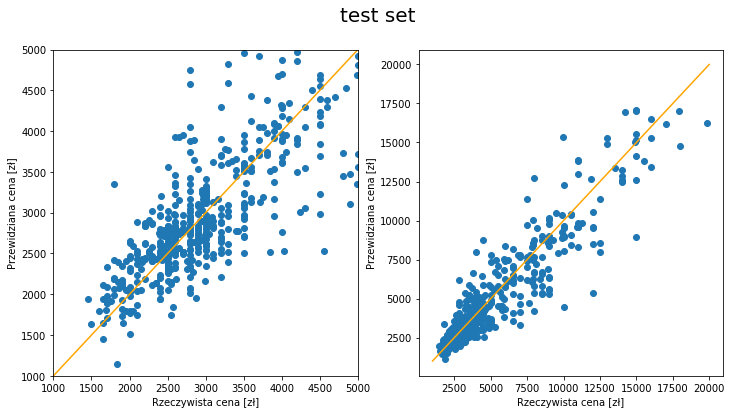

In [727]:
# Calculate error on test set

fig = plt.figure(figsize=(12,6))
y_pred_test = regressor.predict(x_test)

fig.add_subplot(1,2,1)
plt.scatter(y_test, y_pred_test)
plt.plot([1000, 20000], [1000, 20000], color='orange')
plt.xlabel('Rzeczywista cena [zł]')
plt.ylabel('Przewidziana cena [zł]')
plt.xlim(1000, 5000)
plt.ylim(1000, 5000)

fig.add_subplot(1,2,2)
plt.scatter(y_test, y_pred_test)
plt.plot([1000, 20000], [1000, 20000], color='orange')
plt.xlabel('Rzeczywista cena [zł]')
plt.ylabel('Przewidziana cena [zł]')
fig.suptitle('test set', fontsize=20)

mse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_test))
r2 = r2_score(y_test, y_pred_test)
print("Mean square error is {}\nR^2 score is {}".format(mse, r2))

## 4.2. Analyse of error in regression approach

,train error,test error
count,1540.000000,660.000000
mean,1.464502,1.267281
std,17.464296,20.706301
min,-58.265445,-55.427724
25%,-7.109322,-10.186231
50%,0.000702,0.237450
75%,8.123843,10.820885
max,124.024596,120.902703


Text(0.5, 0, 'relative error [%]')

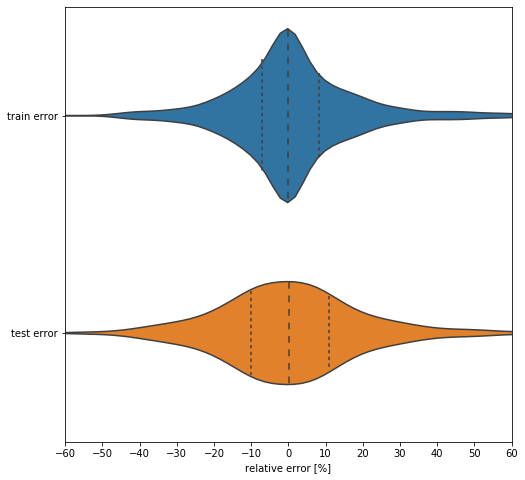

In [728]:
# For all predicted values measure relative difference from exact value and analyse that distribution

train_error = [100*(y_pred_train[i] - float(y_train.iloc[i])) / float(y_train.iloc[i]) for i in range(len(y_train))]
test_error = [100*(y_pred_test[i] - float(y_test.iloc[i])) / float(y_test.iloc[i]) for i in range(len(y_test))]

error_df = pd.DataFrame([train_error, test_error]).T.rename(columns={0:'train error', 1:'test error'})
display(error_df.describe())


plt.figure(figsize=(8,8))
sns.violinplot(data=error_df, inner='quartile', orient='h')
plt.xlim(-50,50)
plt.xticks(np.arange(-60, 65, 10))
plt.xlabel('relative error [%]')

## Comment:

`50% of data` in training set has relative error in range `(-7%, 8%)`, what means about `7.5% relative error` for half of the training set.

Similarly, `50% of data` in test set has relative error inside range `(-10%, 11%)`, which is `10.5% relative error` on average.

**For example:** if we have a sample `out of training set` of apartament that has price `2500 zł in advertisement`, this algorithm has `50% chance` to predict price in range `(2250 zł, 2763 zł)`.

## 4.3. Test on some hand-typed data

In [708]:
test = pd.DataFrame([[45, 2, 52.197751, 20.964537, 2018, 25]], columns=['Powierzchnia', 'Liczba pokoi', 'φ', 'λ', 'Rok budowy', 'Czas dojazdu do centrum'])
test_ = scaler_x.transform(test)
display(test)

print("For an apartment with area = {} m^2, {} room(s), build in {} and located at ({}, {}), predicted price is {} zł.".
      format(test['Powierzchnia'].iloc[0], test['Liczba pokoi'].iloc[0], test['Rok budowy'].iloc[0]
             , test['φ'].iloc[0], test['λ'].iloc[0], round(regressor.predict(test_)[0])))

,Powierzchnia,Liczba pokoi,φ,λ,Rok budowy,Czas dojazdu do centrum
0,45,2,52.197751,20.964537,2018,25


For an apartment with area = 45 m^2, 2 room(s), build in 2018 and located at (52.197751, 20.964537), predicted price is 2948.0 zł.


## Comment:
True price for entered apartament is `3300 zł`, so the relative error is `-10.6%`.